### Reconstruct missing data with greyscale images of cats

Use [Kaggle data](https://www.kaggle.com/datasets/unmoved/30k-cats-and-dogs-150x150-greyscale) containing 15.060 greyscale images (150 x 150) of cats. Stored data in ```/data/raw/cats```.

In [14]:
# Tech preamble:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

### Get familiar with raw data

In [24]:
# set path to data:
cats_folder = "../data/raw/cats"
path_to_data = "../data/raw"

# Get the number of items in cat folder:
num_cats = len(os.listdir(cats_folder))

# Print the number of items in cat folder:
print("Number of items in the cats folder: ", num_cats)

Number of items in the cats folder:  15060


In [6]:
## Import images and convert to numpy array:

# Initialize storage for images:
cats_all = 0

# Specify number of images to load:
n_images = 1300 #len(os.listdir(cats_folder))

# Loop over filenames in cat folder:
for n_file in range(n_images):
    
#     # Print status:
#     print('Loading image',n_file+1,'of',len(os.listdir(cats_folder)))
    
    # Load current image:
    image = Image.open(cats_folder + '/' + os.listdir(cats_folder)[n_file])

    # Convert current image to numpy array, expand dims to have sample dimension (=1) as first dimension:
    image_np = np.expand_dims(np.asarray(image),axis=0)
    
    # Store current image, either initialize storage or concatenate:
    if type(cats_all)==int:
        cats_all = image_np
    else:
        cats_all = np.concatenate([cats_all,image_np])

In [9]:
# Cut edges to have image dimensions 144 x 144, suitable for U-Net with 4 max pooling operations:
cats_all = cats_all[:,:144,:144]

In [12]:
# Export collection of cat images as numpy array:
np.save(path_to_data + '/cats_0_1299.npy', cats_all)

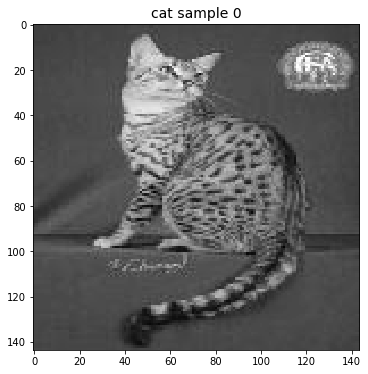

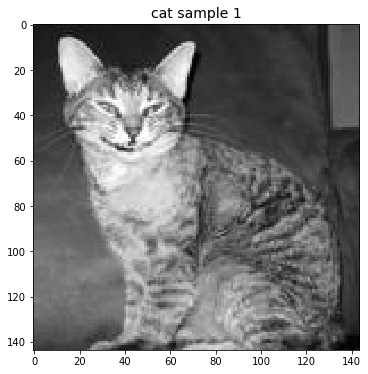

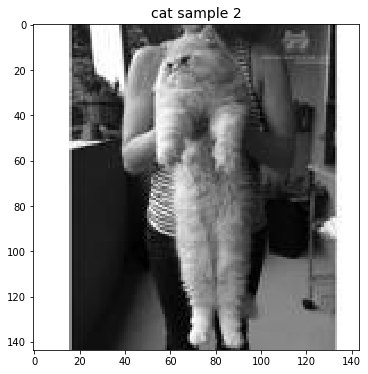

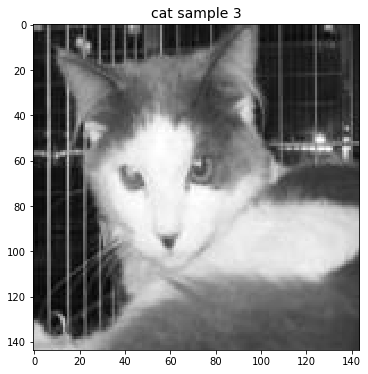

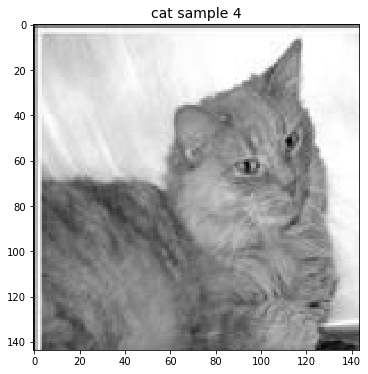

In [20]:
## Plot example images as grayscale heatmaps:

# Set number of samples:
n_samples = 5

# Loop over desired number of samples:
for n in range(n_samples):
    
    # Plot current image:
    fig, ax = plt.subplots(figsize=(6, 6))
    im = plt.imshow(cats_all[n], cmap="gray", interpolation='nearest')#, vmax=0.003)
    #cbar = plt.colorbar(im)
    plt.title('cat sample '+str(n), fontsize=14)
    plt.show()

### Preprocessing and Model preparation

In [23]:
# Tech preamble:
from reconstruct_missing_data.data_loading import (
    clone_data,
    create_missing_mask,
    split_and_scale_data,
)
from reconstruct_missing_data.models import build_unet_4conv

In [26]:
### Set parameters up-front:

# Path to collection of cats images as numpy array:
path_to_data = "../data/raw"

# Model configuration, to store results:
model_config = "unet_4conv"

# Data loading and preprocessing:
source = "cats_1300"  # Choose Earth System Model, either 'FOCI' or 'CESM'.
seed = 1  # Seed for random number generator, for reproducibility of missing value mask.
mask_type = "variable"  # Can have random missing values, individually for each data sample ('variable'),
# or randomly create only a single mask, that is then applied to all samples identically ('fixed').
missing_type = "discrete"  # Either specify discrete amounts of missing values ('discrete') or give a range ('range').
augmentation_factor = (
    2  # Number of times, each sample is to be cloned, keeping the original order.
)
train_val_split = 0.8  # Set rel. amount of samples used for training.
missing_values = [
    0.999,
    0.99,
    0.95,
    0.9,
    0.75,
    0.5,
]  # Set array for desired amounts of missing values: 0.9 means, that 90% of the values are missing.
# Or set a range by only giving minimum and maximum allowed relative amounts of missing values,
# e.g. [0.75, 0.95], according to missing_type 'discrete' or 'range', respectively.
scale_to = "zero_one"  # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one') or 'norm' to normalize inputs or 'no' scaling.

# To build, compile and train model:
CNN_filters = [64, 128, 256, 512]  # [2,4,8,16] # Number of filters.
CNN_kernel_size = 5  # Kernel size
learning_rate = 0.0001
loss_function = "mse"
epochs = 10
batch_size = 10

In [28]:
# temp:
missing=0.99

# Extend data, if desired:
data = clone_data(data=cats_all, augmentation_factor=augmentation_factor)

# Create mask for missing values:
missing_mask = create_missing_mask(
    data=data,
    mask_type=mask_type,
    missing_type=missing_type,
    missing_min=missing,
    missing_max=missing,
    seed=seed,
)

In [37]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets.
# Scale or normlalize data according to statistics obtained from only training data.
(
    train_input,
    val_input,
    train_target,
    val_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = split_and_scale_data(data, missing_mask, train_val_split, scale_to)

# Build and compile U-Net model:
model = build_unet_4conv(
    input_shape=(train_input.shape[1], train_input.shape[2], 1),
    CNN_filters=CNN_filters,
    CNN_kernel_size=CNN_kernel_size,
    learning_rate=learning_rate,
    loss_function=loss_function,
)

2023-06-10 21:35:54.265879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
train_input.shape

(2080, 144, 144, 1)